In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
%matplotlib inline

### Read and Import  the Database

In [2]:
stocks = pd.read_csv(r"./databank/sphist.csv")
stocks["Date"] = pd.to_datetime(stocks["Date"])
stocks = stocks.sort_values(by="Date", ascending=True)

# Prepare a separate copy of the data frame to execute and protect the original data frame
shares = stocks.copy()
print(shares.head())

            Date   Open   High    Low  Close     Volume  Adj Close
16589 1950-01-03  16.66  16.66  16.66  16.66  1260000.0      16.66
16588 1950-01-04  16.85  16.85  16.85  16.85  1890000.0      16.85
16587 1950-01-05  16.93  16.93  16.93  16.93  2550000.0      16.93
16586 1950-01-06  16.98  16.98  16.98  16.98  2010000.0      16.98
16585 1950-01-09  17.08  17.08  17.08  17.08  2520000.0      17.08


### Resetting the Database Index for ease of moving average calcs

In [3]:
shares.reset_index(inplace=True, drop=True)

### Initializing new columns for the Database

In [4]:
shares["Day_5"] = 0
shares["Day_30"] = 0
shares["Day_365"] = 0
shares["D30_D5"] = 0 
shares["D365_D30"] = 0
shares["Std_5"] = 0
shares["Std_30"] = 0
shares["Std_365"] = 0
shares["Std30_Std5"] = 0
shares["Std365_Std30"] = 0

#### Developing the Average Share Prices and Standard Deviations for the past 5 Days, 30 Days & 365 Days

In [5]:
temp_val = list() 
# Number of training examples to be considered for the analysis based on moving average req't
no_days = [5, 30, 365]
m = shares.index[-1] - (max(no_days) - 1)

# Moving Average of Market Close for the past 5, 30, 365 days
for i in range(len(no_days)):
    j = shares.index[0]
    while j <= (m + no_days[i]):
        shares.loc[j, "Day_"+ str(no_days[i])] = np.mean(shares['Close'].loc[j + 1: j + no_days[i]])
        shares.loc[j, "Std_"+ str(no_days[i])] = np.std(shares['Close'].loc[j + 1: j + no_days[i]])
        j += 1

### Preparing new columns using the moving average & standard deviation Data

In [6]:
shares["D30_D5"] = shares["Day_30"] / shares["Day_5"]
shares["D365_D30"] = shares["Day_365"] / shares["Day_30"]
shares["Std30_Std5"] = shares["Std_30"] / shares["Std_5"]
shares["Std365_Std30"] = shares["Std_365"] / shares["Std_30"]

### Checking the moving average, variance and new columns' output

In [7]:
out_cols = ["Date", "Close", "Day_5", "Day_30", "Day_365", "Std_5", "Std_30", "Std_365", "D30_D5", "D365_D30", "Std30_Std5", "Std365_Std30"]
shares[out_cols].head(5)

,Date,Close,Day_5,Day_30,Day_365,Std_5,Std_30,Std_365,D30_D5,D365_D30,Std30_Std5,Std365_Std30
0,1950-01-03,16.66,16.974,16.990000,19.462411,0.079649,0.186011,1.786854,1.000943,1.145522,2.335370,9.606186
1,1950-01-04,16.85,17.022,16.994667,19.476274,0.060465,0.184187,1.786161,0.998394,1.146023,3.046183,9.697534
2,1950-01-05,16.93,16.988,17.002000,19.489562,0.120565,0.185839,1.785209,1.000824,1.146310,1.541393,9.606230
3,1950-01-06,16.98,16.926,17.009333,19.502082,0.175795,0.189137,1.783589,1.004923,1.146552,1.075894,9.430131
4,1950-01-09,17.08,16.854,17.012333,19.513617,0.171651,0.190940,1.781500,1.009394,1.147028,1.112370,9.330180


### Get the Feel About the Target Column 

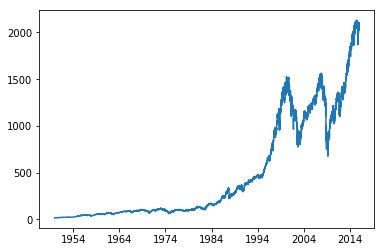

In [8]:
plt.plot(shares['Date'], shares['Close'])
plt.show()

### Converting the datetime data of Date column into meaningful numeric form for regression

In [9]:
# Feature Scaling for Logistic Regression

dy_sc = []
dy_sc.clear()
dt_min = min(shares['Date'])
dt_max = max(shares['Date'])

for i in range(len(shares['Date'])):
    dy_sc.append((shares['Date'][i] - dt_min)/(dt_max-dt_min))
shares['Days'] = dy_sc
print("\n Date Scaling Vector:\n", shares['Days'].iloc[0:10])


 Date Scaling Vector:
 0    0.000000
1    0.000042
2    0.000083
3    0.000125
4    0.000249
5    0.000291
6    0.000332
7    0.000374
8    0.000415
9    0.000540
Name: Days, dtype: float64


In [10]:
shares = shares.loc[:m]
shares.dropna(axis=0, how="any")
print(shares.isnull().sum().sum())

0


### Feature Correlation Matrix to understand predictive target influence


 Correlation Matrix: 
 Open            0.999892
High            0.999950
Low             0.999952
Close           1.000000
Volume          0.755750
Adj Close       1.000000
Day_5           0.999784
Day_30          0.999128
Day_365         0.987509
D30_D5               NaN
D365_D30             NaN
Std_5           0.735871
Std_30          0.796776
Std_365         0.871603
Std30_Std5           NaN
Std365_Std30         NaN
Days            0.868305
Name: Close, dtype: float64

 Correlation Heatmap



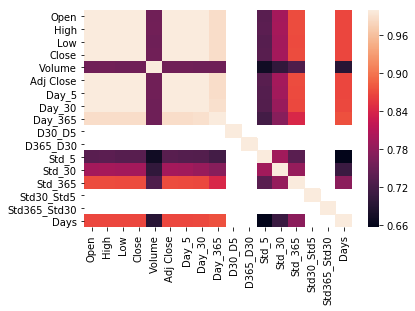

In [11]:
all_cols = shares.columns.values
corrmat = shares.corr()
corrmat = corrmat[corrmat >= 0.3]
print("\n Correlation Matrix: \n", corrmat['Close'])
print("\n Correlation Heatmap\n")
sns.heatmap(corrmat)
plt.show()

### Preparing Features List per Influential Significance

In [12]:
feature = ['Adj Close', 'Low', 'High',  'Open',  'Day_365', 'Days', 'Day_30', 'Day_5', 'Std_365', 'Volume', 'Std_30', 'Std_5']
target = ["Close"]

### Extracting the Training / Test / Cross-Validation Sets

In [13]:
# Split Training/Test/CV set 60/20/20

train_set = shares[shares["Date"] > '1976-06-23']
test_set = shares[(shares["Date"] <= '1976-06-23') & (shares["Date"] > '1963-03-19')]
cross_val = shares[shares["Date"] <= '1963-03-19']

### Develop Linear Regression and Train it over the Training Set

In [14]:
train_feature = train_set[feature]
train_target = train_set[target]

lrr = LinearRegression()
lrr.fit(train_feature, train_target)
predictions_train = lrr.predict(train_feature)
mse_train = mean_absolute_error(predictions_train, train_target)

print("\n MAE for training set =", mse_train)


 MAE for training set = 1.0738542107308132e-10


### Compare Model Fit Over Training Set

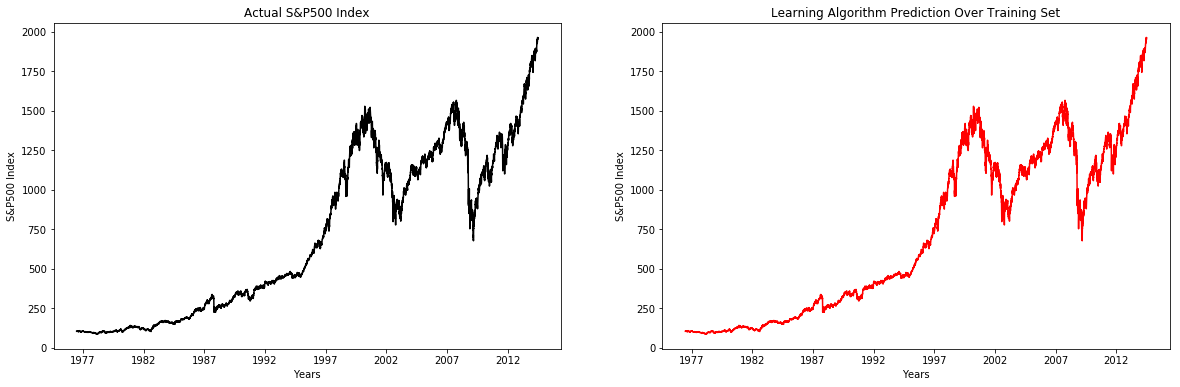

In [15]:
fig = plt.figure(figsize=(20,6))

for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    if i == 0:
        plt.plot(train_set['Date'], train_target, c='black')
        plt.title('Actual S&P500 Index')
    else:
        plt.plot(train_set['Date'], predictions_train, c='red')
        plt.title('Learning Algorithm Prediction Over Training Set')
    plt.xlabel('Years')
    plt.ylabel('S&P500 Index')
    
plt.show()

### Verify the Learning Algorithm over the Test Set

In [16]:
test_feature = test_set[feature]
test_target = test_set[target]

lrr = LinearRegression()
lrr.fit(train_feature, train_target)
predictions_test = lrr.predict(test_feature)
mse_test = mean_absolute_error(predictions_test, test_target)

print("\n MAE for test set =", mse_test)


 MAE for test set = 1.0190167911144772e-10


### Compare Prediction Error over Test Set

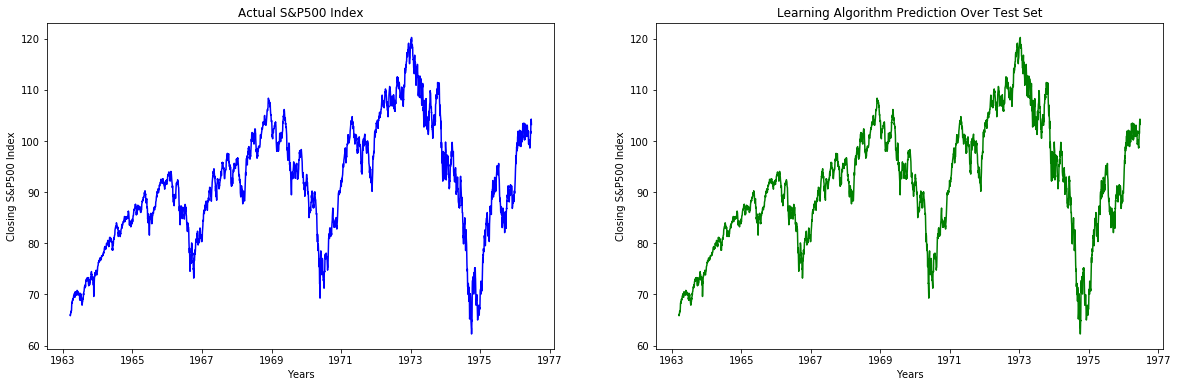

In [17]:
fig = plt.figure(figsize=(20,6))

for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    if i == 0:
        plt.plot(test_set['Date'], test_target, c='blue')
        plt.title('Actual S&P500 Index')
    else:
        plt.plot(test_set['Date'], predictions_test, c='green')
        plt.title('Learning Algorithm Prediction Over Test Set')
    plt.xlabel('Years')
    plt.ylabel('Closing S&P500 Index')
    
plt.show()

The above graph shows how closely the model predicted over the test set.

### Checking the Learning Algorithm Predictibility on Cross-Validation set 

In [18]:
train_feature = train_set[feature]
train_target = train_set[target]
cv_feature =cross_val[feature]
cv_target = cross_val[target]

lrr = LinearRegression()
lrr.fit(train_feature, train_target)
predictions_cv = lrr.predict(cv_feature)
mse_cv = mean_absolute_error(predictions_cv, cv_target)

print("\n MAE for cross-validation set =", mse_cv)


 MAE for cross-validation set = 1.0219626343663962e-10


### Model Prediction Comparison over Cross-Validation Set

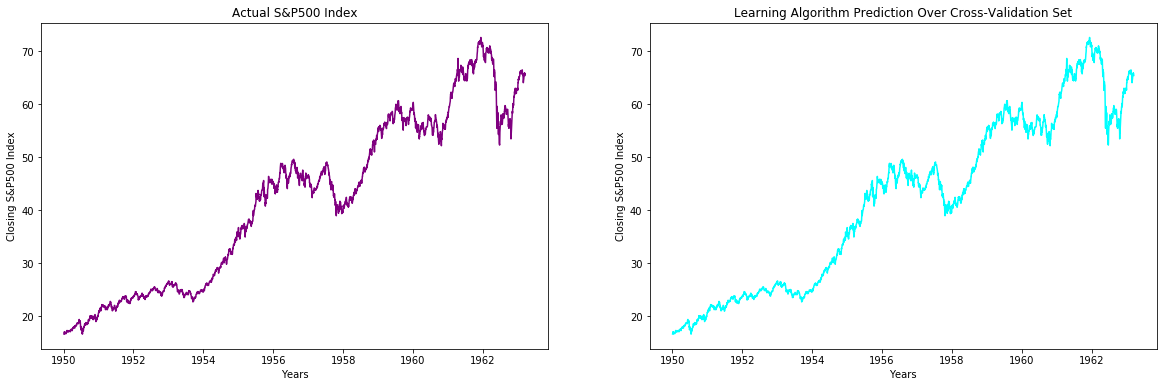

In [19]:
fig = plt.figure(figsize=(20,6))

for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    if i == 0:
        plt.plot(cross_val['Date'], cv_target, c='purple')
        plt.title('Actual S&P500 Index')
    else:
        plt.plot(cross_val['Date'], predictions_cv, c='cyan')
        plt.title('Learning Algorithm Prediction Over Cross-Validation Set')
    plt.xlabel('Years')
    plt.ylabel('Closing S&P500 Index')
    
plt.show()

Model predicted closely with the actual S&P500 Index movement while tested over the unknown cross-validation data.

### Conclusion